# Course Project - Fake News Detection- Using Neural Nets

### Importing the required modules

In [20]:
import json
import numpy as np
import pandas as pd
import torch.nn as nn
import numpy as np
import random
from bpemb import BPEmb

### Reading the train.json file 

In [21]:
# load metadata
with open(r"train.json", 'r') as f:
    metadata = json.load(f)
n_claims = len(metadata)

In [22]:
train_df=pd.DataFrame(metadata)

In [23]:
train_df.head()

,claim,claimant,date,id,label,related_articles
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]"
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]"
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]"
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]"
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]"


In [16]:
train_df['claim'].head()

0    A line from George Orwell's novel 1984 predict...
1    Maine legislature candidate Leslie Gibson insu...
2    A 17-year-old girl named Alyssa Carson is bein...
3    In 1988 author Roald Dahl penned an open lette...
4    When it comes to fighting terrorism, "Another ...
Name: claim, dtype: object

In [5]:
n_embedding_dims = 50
bpemb_en = BPEmb(lang="en", dim=n_embedding_dims)

def sampleClaim(metadata): 
    id = random.randint(0, len(metadata) - 1)
    claim = metadata[id]["claim"]
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch
                                .float)
    return claim_tensor, label_tensor, claim, label, id
  
def sampleClaimAndClaimant(metadata): 
    id = random.randint(0, len(metadata) - 1)
    claim = metadata[id]["claim"] + ' ' + metadata[id]["claimant"]
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id

**Giving our words context: The positional encoding**

*In order for the model to make sense of a sentence, it needs to know two things about each word: what does the word mean? And what is its position in the sentence?
The embedding vector for each word will learn the meaning, so now we need to input something that tells the network about the word’s position.*

In [24]:
from torch.autograd import Variable
import math
import copy

class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 80):
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** (i / d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** (i / d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        # add constant to embedding
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], requires_grad=False) #.cuda()
        return x

*The above module lets us add the positional encoding to the embedding vector, providing information about structure to the model.
The reason we increase the embedding values before addition is to make the positional encoding relatively smaller. This means the original meaning in the embedding vector won’t be lost when we add them together.*

**Creating Our Masks**
*Masking plays an important role in the transformer. It serves two purposes:*
    1. In the encoder and decoder: To zero attention outputs wherever there is just padding in the input sentences.
    2. In the decoder: To prevent the decoder ‘peaking’ ahead at the rest of the translated sentence when predicting the next word.

In [25]:
import torch.nn.functional as F

def attention(q, k, v, d_k, mask=None, dropout=None):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output

**Multi-Headed Attention**

*Once we have our embedded values (with positional encodings) and our masks, we can start building the layers of our model.*

In [26]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
                
        # transpose to get dimensions bs * h * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        
        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        
        output = self.out(concat)
    
        return output

**The Feed-Forward Network**

*This layer just consists of two linear operations, with a relu and dropout operation in between them.The feed-forward layer simply deepens our network, employing linear layers to analyse patterns in the attention layers output.*

In [27]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

**Normalisation**

*Normalisation is highly important in deep neural networks. It prevents the range of values in the layers changing too much, meaning the model trains faster and has better ability to generalise.We will be normalising our results between each layer in the encoder/decoder*

In [28]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

In [29]:
# build an encoder layer with one multi-head attention layer and one 
# feed-forward layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

      
# We can then build a convenient cloning function that can generate multiple layers:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [30]:
class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super().__init__()
        self.N = N
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    
    def forward(self, src, mask):
        x = self.pe(src)
        for i in range(N):
            x = self.layers[i](x, mask)
        return self.norm(x)

In [31]:
class Transformer(nn.Module):
    def __init__(self, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(d_model, N, heads)
        
    def forward(self, src, src_mask):
        e_outputs = self.encoder(src, src_mask)
        output = torch.sum(e_outputs, dim=0)
        return output

In [32]:
class Classifier(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Classifier, self).__init__()
        self.hidden_size = hidden_size
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, hidden):
        hidden = self.h2o(hidden)
        output = self.softmax(hidden)
        return output

In [33]:
import torch
d_model = 50   # 200
heads = 2      # 8
N = 6
n_categories = 3
model = Transformer(d_model, N, heads)
classifier = Classifier(d_model, n_categories)

criterion = nn.NLLLoss()
learning_rate = 1e-4

optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

In [34]:
def train(category_tensor, line_tensor, update=True):
    optim.zero_grad()
    classifierOptimizer.zero_grad()

    hidden = model(line_tensor, None)
    output = classifier(hidden)

    loss = criterion(output, category_tensor)
    if update:
        loss.backward()
        optim.step()
        classifierOptimizer.step()
        
    return output, loss.item()

In [35]:
import time

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


## Building nn based on just claims

In [23]:
n_iters = 10000
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

train_data = metadata[:10000]
test_data = metadata[10000:]

train_cumulative_loss = 0
test_cumulative_loss = 0
average_train_accuracy = 0
average_test_accuracy = 0

all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []

count = 0
for iter in range(1, n_iters + 1):
    train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaim(train_data)
    train_output, train_loss = train(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)
    
    test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaim(test_data)
    test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
    test_cumulative_loss += test_loss
    test_accuracy = 1 if test_guess_category == test_category else 0
    average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)
    count += 1

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, train_line, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every, test_line, test_guess_category, test_correct))
        
        all_train_losses.append(train_cumulative_loss / plot_every)
        all_train_accuracies.append(average_train_accuracy)
        all_test_losses.append(test_cumulative_loss / plot_every)
        all_test_accuracies.append(average_test_accuracy)
        
        train_cumulative_loss = 0
        average_train_accuracy = 0
        test_cumulative_loss = 0
        average_test_accuracy = 0
        count = 0

Train: 100  1% (0m 8s) average_accuracy=0.2900 average_loss=4.5144 Said Adolf Hitler and Donald Trump have both described deportations as "a military operation." / 1 ✓
Test: 100  1% (0m 8s) average_accuracy=0.4000 average_loss=2.8043 President Donald Trump and his family will be the subjects of an upcoming reality show. / 1 ✗ (0)
Train: 200  2% (0m 17s) average_accuracy=0.2900 average_loss=9.2461 Elizabeth II is abdicating her throne and giving the crown to Prince William / 2 ✗ (0)
Test: 200  2% (0m 17s) average_accuracy=0.3800 average_loss=13.0028 Says she "created the first felony deferred prosecution program for nonviolent first-offenders" in Texas. / 0 ✗ (1)
Train: 300  3% (0m 28s) average_accuracy=0.4400 average_loss=6.4951 Says Melania Trump hired exorcist to "cleanse White House of Obama demons." / 1 ✗ (0)
Test: 300  3% (0m 28s) average_accuracy=0.4800 average_loss=5.5543  "Many of our best and brightest are leaving the medical profession entirely because of Obamacare."  / 1 ✗ (

Train: 2100  21% (4m 35s) average_accuracy=0.4400 average_loss=1.0567 In Miami-Dade County, "we spend at our school system over $20 million every year" educating recent immigrants. / 1 ✓
Test: 2100  21% (4m 35s) average_accuracy=0.4900 average_loss=1.2693 Since 2009, "millions of Americans have lost their health care plans." / 1 ✓
Train: 2200  22% (4m 49s) average_accuracy=0.4600 average_loss=1.3877 The NFL is "getting massive tax breaks." / 1 ✓
Test: 2200  22% (4m 49s) average_accuracy=0.4900 average_loss=1.3393 Hours after Massachusetts legalized recreational marijuana, the state had its first cannabis overdose.

				
					

						See Example(s)

						
							
								
									A fake news article has been going around claiming that "the first recorded marijuana overdose" happened at 2AM this morning in Massachusetts:

https://theamericantribune.org/posts/first-recorded-marijuana-overdose-occurs-hours-after-mass-legalization																			Collected via e-mail, December 2016 / 1 

Train: 4200  42% (9m 25s) average_accuracy=0.4700 average_loss=1.6668 TSA confiscated nail clippers from a U.S. soldier returning from Afghanistan on a flight full of armed soldiers. / 0 ✓
Test: 4200  42% (9m 25s) average_accuracy=0.4500 average_loss=1.6555 UN, EU and George Soros giving migrants prepaid cards to ‘fund their way through Europe’ / 0 ✓
Train: 4300  43% (9m 38s) average_accuracy=0.3300 average_loss=1.4358 "All the data that you put in, all the content that you share on Facebook, is yours." / 1 ✓
Test: 4300  43% (9m 38s) average_accuracy=0.5200 average_loss=1.0213 The Obama administration is moving to ban donut sprinkles. / 0 ✓
Train: 4400  44% (9m 52s) average_accuracy=0.4800 average_loss=2.1936 "Each year ICE detains someone, it costs taxpayers over $50,000. For comparison, by the way, that's four times the amount the federal government spends on each child in our public schools." / 0 ✗ (1)
Test: 4400  44% (9m 52s) average_accuracy=0.4700 average_loss=2.8032 "Oil compani

Train: 6400  64% (14m 27s) average_accuracy=0.5000 average_loss=1.1099 The Obama administration secretly bribed Iran to release four prisoners in January 2016.

				
					

						See Example(s)

						
							
								
									Did US Bribe Iran To Release Americans? $400 Million, Report Says
http://www.ibtimes.com/did-us-bribe-iran-release-americans-400-million-report-says-2397164																			Collected via Internet, August 2016 / 0 ✓
Test: 6400  64% (14m 27s) average_accuracy=0.5100 average_loss=1.0104  Wrote that President Donald Trump was rushed to the hospital after collapsing while giving a speech in New Jersey.  / 0 ✓
Train: 6500  65% (14m 40s) average_accuracy=0.5600 average_loss=0.9735 "When Jeb (Bush) was governor, his first four years as governor, his Medicaid program grew twice as fast as mine." / 1 ✓
Test: 6500  65% (14m 40s) average_accuracy=0.4900 average_loss=0.9136 Electricity production was 1.8 TWh in 2003 and 2017. / 2 ✗ (0)
Train: 6600  66% (14m 54s) average_ac

Train: 7600  76% (17m 11s) average_accuracy=0.4900 average_loss=0.9294 Mohammed Atta, a convicted terrorist released by Israel at the insistence of the U.S., participated in the 9/11 terrorist attacks.

				
					

						See Example(s)

						
							
								
									I received this e-mail note today, from a reliable source. What can we say?

An Arab terrorist named Atta blew up a bus in Israel in 1986. The Israelis captured, tried and imprisoned him. As part of the Oslo agreement Israel had to agree to release so called "political prisoners". However, Israeli officials insisted that they would not release any with "blood on their hands". Some well meaning American President and Secretary of State insisted that all be released.

Thus Mr. Atta was freed and eventually thanked the US by flying an airplane into Tower One of the World Trade Center. This was reported by many of the networks at the time the terrorists were first identified. It was missing from later reports. That President

Train: 9200  92% (20m 57s) average_accuracy=0.4200 average_loss=1.4618 An epidemic has resulted in an outbreak of ‘zombism.’ / 0 ✓
Test: 9200  92% (20m 57s) average_accuracy=0.4500 average_loss=2.1058 "I was totally against the war in Iraq." / 0 ✓
Train: 9300  93% (21m 11s) average_accuracy=0.5200 average_loss=0.9731 Fisherman on Réunion Island employ live dogs as bait for shark-fishing. / 0 ✗ (1)
Test: 9300  93% (21m 11s) average_accuracy=0.4400 average_loss=1.3106 Says New Jersey is "losing 50 football fields of open space to development every day and the more we develop upstream the more flooding we have downstream." / 0 ✗ (1)
Train: 9400  94% (21m 25s) average_accuracy=0.5400 average_loss=0.9142 "Midtown crime is up by 30 percent the last quarter." / 0 ✗ (1)
Test: 9400  94% (21m 25s) average_accuracy=0.4700 average_loss=0.9491 "Almost 88,000 United States service members are still missing and unaccounted for, dating back to World War II." / 0 ✗ (1)
Train: 9500  95% (21m 38s) averag

In [26]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_train_accuracies)
plt.plot(all_test_accuracies)
plt.title('Q2b (i) claim only')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (by Hundread)')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')
plt.show()

<Figure size 640x480 with 1 Axes>

In [27]:
d_model = 50
heads = 2
N = 6
n_categories = 3
model = Transformer(d_model, N, heads)
classifier = Classifier(d_model, n_categories)

criterion = nn.NLLLoss()
learning_rate = 1e-4

optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

## Building NN based on claim and claimant

In [28]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

train_data = metadata[:10000]
test_data = metadata[10000:]
train_cumulative_loss = 0
test_cumulative_loss = 0
average_train_accuracy = 0
average_test_accuracy = 0
all_train_losses_2 = []
all_train_accuracies_2 = []
all_test_losses_2 = []
all_test_accuracies_2 = []
count = 0
for iter in range(1, n_iters + 1):
    train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaimAndClaimant(train_data)
    train_output, train_loss = train(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)
    
    test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaimAndClaimant(test_data)
    test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
    test_cumulative_loss += test_loss
    test_accuracy = 1 if test_guess_category == test_category else 0
    average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)
    count += 1

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, train_line, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every, test_line, test_guess_category, test_correct))
        all_train_losses_2.append(train_cumulative_loss / plot_every)
        all_train_accuracies_2.append(average_train_accuracy)
        all_test_losses_2.append(test_cumulative_loss / plot_every)
        all_test_accuracies_2.append(average_test_accuracy)
        train_cumulative_loss = 0
        average_train_accuracy = 0
        test_cumulative_loss = 0
        average_test_accuracy = 0
        count = 0
        

Train: 100  1% (0m 15s) average_accuracy=0.4600 average_loss=8.2317 Says he would be first CPA to serve as Texas comptroller. Raul Torres / 1 ✗ (2)
Test: 100  1% (0m 15s) average_accuracy=0.4100 average_loss=10.0954  SHAQUILLE O’NEAL SAYS: 'TRUMP IS POSSIBLY THE BEST PRESIDENT OF THE PRESIDENT OF ALL TIMES EVER, HE IS NOT AFRAID TO… .’  Nebraska Daily / 0 ✓
Train: 200  2% (0m 30s) average_accuracy=0.4400 average_loss=8.5512 Tax reform plans proposed by House and Senate Republicans in November 2017 would remove the deduction for employee discounts.  / 0 ✓
Test: 200  2% (0m 30s) average_accuracy=0.4000 average_loss=7.0697 General Motors is resurrecting the Pontiac Firebird Trans Am for 2015.  / 0 ✓
Train: 300  3% (0m 44s) average_accuracy=0.3900 average_loss=4.2187 "Today, property taxes are lower than they were in 2010." John Nygren / 0 ✗ (1)
Test: 300  3% (0m 44s) average_accuracy=0.5000 average_loss=3.4650 About 750,000 people die in China each year from auto emissions. Nancy Pelosi /

Train: 2200  22% (5m 32s) average_accuracy=0.4100 average_loss=1.7574 There "is the standard which every other Supreme Court nominee has had to meet, and that is earning 60 bipartisan votes in the United States Senate.” Tammy Baldwin / 0 ✗ (1)
Test: 2200  22% (5m 32s) average_accuracy=0.4700 average_loss=1.9380 “Human traffickers and sex traffickers take advantage of the wide-open areas between our ports of entry to smuggle thousands of young girls and women into the United States and to sell them into prostitution and modern-day slavery.” Donald Trump / 1 ✗ (0)
Train: 2300  23% (5m 47s) average_accuracy=0.3300 average_loss=1.4666 President Donald Trump's proposed 2020 re-election campaign slogan ("Keep America Great") was used in a 'Purge' film.

				
					

						See Example(s)

						
							
								
									Is anyone else a little disconcerted that Trump's 2020 slogan "Keep America Great" is directly from the Purge movie?— Thomas C. (@Thomas_Conerty) January 18, 2017
												

Train: 3900  39% (9m 53s) average_accuracy=0.5500 average_loss=1.6240  "The SOTU had more viewers than the Super Bowl"  Social media posts / 0 ✓
Test: 3900  39% (9m 53s) average_accuracy=0.3700 average_loss=1.9849 "When I say Mexico is going to pay for the wall, that's what I said. Mexico is going to pay. I didn't say they're going to write me a check for $20 billion or $10 billion." Donald Trump / 1 ✗ (0)
Train: 4000  40% (10m 8s) average_accuracy=0.4700 average_loss=1.1955 "There are no federal or state laws that say prosecutors must seek death sentences. And the United States Supreme Court has banned all state laws that make executions mandatory for murders." Randolph Bracy / 0 ✗ (2)
Test: 4000  40% (10m 8s) average_accuracy=0.4400 average_loss=1.3561 Starbucks COO Rosalind Brewer once expressed the viewpoint that "white men are the root of all evil."  / 0 ✓
Train: 4100  41% (10m 23s) average_accuracy=0.4400 average_loss=2.1931 "Within the three miles surrounding the University Circ

Train: 5900  59% (14m 59s) average_accuracy=0.4300 average_loss=1.3422 "She (Kagan) took money from Goldman Sachs just like her boss, Obama." Michael Savage / 0 ✗ (1)
Test: 5900  59% (14m 59s) average_accuracy=0.4400 average_loss=1.4078  The “best studies” show that “somewhere between 40[000] and 80,000 people were turned away from the polls” in Wisconsin in 2016 because of the state’s voter ID law.  Hillary Clinton / 0 ✓
Train: 6000  60% (15m 15s) average_accuracy=0.4900 average_loss=1.5732 Says British voters "under 50, especially millennials, overwhelmingly voted to stay," in the European Union. "It was older voters who voted to leave." Tim Kaine / 0 ✗ (1)
Test: 6000  60% (15m 15s) average_accuracy=0.4800 average_loss=1.3708 New Virginia regulations on abortion clinics "provide the same sanitary environment we expect of dental offices." Susan B. Anthony List / 0 ✓
Train: 6100  61% (15m 30s) average_accuracy=0.4500 average_loss=2.0495 A bipartisan background check amendment "outlawed

Train: 7300  73% (18m 31s) average_accuracy=0.4400 average_loss=1.1183 Says the Austin metro region "will lead" the nation "with population growth over 50%" over the next 30 years. John Thomaides / 1 ✓
Test: 7300  73% (18m 31s) average_accuracy=0.4900 average_loss=1.1309 A large root system was discovered below Devil's Tower in Wyoming.  / 0 ✓
Train: 7400  74% (18m 46s) average_accuracy=0.3700 average_loss=1.3853 Says two-thirds of groups targeted for IRS scrutiny were not conservative. Progress Texas / 1 ✗ (0)
Test: 7400  74% (18m 46s) average_accuracy=0.5200 average_loss=1.0998 Earth's magnetosphere collapsed for two hours on 23 April 2016.

				
					

						See Example(s)

						
							
								
									Planet Earth's Magnetic field collapsed for 2& 1/2 hours, family. https://t.co/fBQPQcZshL

— ErykahBadoula (@fatbellybella) April 26, 2016
																			Collected via Twitter, April 2016  / 1 ✗ (0)
Train: 7500  75% (19m 2s) average_accuracy=0.4100 average_loss=1.3985 "Wendy D

Train: 9200  92% (23m 21s) average_accuracy=0.4600 average_loss=1.0123 "We've doubled our use of renewable energy." Barack Obama / 2 ✗ (1)
Test: 9200  92% (23m 21s) average_accuracy=0.5100 average_loss=0.9063 “We expect a great atmosphere in Russia… a smooth operation and everything is done for the fans.” Gianni Infantino / 0 ✗ (1)
Train: 9300  93% (23m 35s) average_accuracy=0.4700 average_loss=1.1418 “We’re releasing them [undocumented immigrants] into sanctuary cities almost exclusively. You know, sanctuary cities want them. But once we started releasing them, they didn’t want them. So, you know, they want them, they talk — they talk a good game. But once you start saying: ‘Okay. Congratulations. Here are some.’ And they don’t want them. And they fight very hard. So, the whole sanctuary city thing is a big scam.” Donald Trump / 1 ✗ (0)
Test: 9300  93% (23m 35s) average_accuracy=0.4900 average_loss=1.1029 The Dalai Lama is has renounced religion and is pursuing a career as a sitcom wr

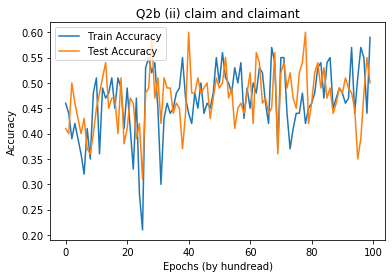

In [29]:
plt.figure()
plt.plot(all_train_accuracies_2)
plt.plot(all_test_accuracies_2)
plt.title('Q2b (ii) claim and claimant')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (by hundread)')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')

In [39]:
def preprocess_articles():

    from nltk.tokenize import sent_tokenize
    import nltk
    nltk.download('punkt')
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    # load metadata
    with open("train.json", 'r') as f:
        metadata = json.load(f)
    n_claims = len(metadata)

    # load related articles for each claim
    relevant_sentences = []
    for id in range(n_claims):
        if id % 500 == 0:
            print("Claims preprocessed: ",id)
        
        # retrieve related articles
        related_articles = metadata[id]['related_articles']
        articles = ""
        for article_id in related_articles:
            filename = r"train_articles"+"\\" + str(article_id) + ".txt"
            # concatenate related articles
            with open(filename, 'rb') as text_file:
                text = str(text_file.read())
                articles = articles + "\n" + text

        # split articles into sentences
        sentences = sent_tokenize(articles)

        # append claim to articles
        sentences.append(metadata[id]['claim'])

        # vectorize sentences based on tf-idf
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(sentences)
    
        # measure similarity between claim and each sentence
        similarity =  X[-1,:] @ np.transpose(X[:-2,:])
        similarity = similarity.todense()

        # find top 5 sentences with greatest similarity
        sorted_index = np.argsort(similarity)
        top_sentences = []
        for i in range(1,min(5,sorted_index.shape[1])+1):
            top_sentences.append(sentences[sorted_index[0,-i]])
        relevant_sentences.append(top_sentences)

    return metadata, relevant_sentences

metadata, relevant_sentences = preprocess_articles()
print("Metadata of claim 0:")
print(metadata[0]['claim'])
print("Relevant sentences of claim 0:")
print(relevant_sentences[0])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Claims preprocessed:  0
Claims preprocessed:  500
Claims preprocessed:  1000
Claims preprocessed:  1500
Claims preprocessed:  2000
Claims preprocessed:  2500
Claims preprocessed:  3000
Claims preprocessed:  3500
Claims preprocessed:  4000
Claims preprocessed:  4500
Claims preprocessed:  5000
Claims preprocessed:  5500
Claims preprocessed:  6000
Claims preprocessed:  6500
Claims preprocessed:  7000
Claims preprocessed:  7500
Claims preprocessed:  8000
Claims preprocessed:  8500
Claims preprocessed:  9000
Claims preprocessed:  9500
Claims preprocessed:  10000
Claims preprocessed:  10500
Claims preprocessed:  11000
Claims preprocessed:  11500
Claims preprocessed:  12000
Claims preprocessed:  12500
Claims preprocessed:  13000
Claims preprocessed:  13500
Claims preprocessed:  14000
Claims preprocessed:  14500
Claims preprocessed:  15000
Claims preprocessed:  15500
Metadata of claim 0:
A line from George Orwell's novel 1984 predicts the power of smartphones.
Relevant sentences of claim 0:
["

In [43]:
train_df['relevant_sentences'] =relevant_sentences

In [45]:
train_df['relevant_sentences'][0]

["b'1984 by George Orwell\\n1984 is a dystopian novel by English author George Orwell published in 1949.",
 'b\'Theater Review: \\\'1984\\\'\\nEarly this year, sales of George Orwell\\\'s novel "1984" spiked after the words "alternative facts" entered the lexicon.',
 "\nb'1984: George Orwell predicted 2017 almost 70 years ago\\nApril, 1984.",
 'NY1\\\'s Roma Torre filed the following review.\\n\\nIt is truly frightening to see the parallels between George Orwell\\\'s dystopian novel "1984" and the state of our union today.\\n\\nOrwell wrote of "doublethink" and "Newspeak."',
 'The main protagonist is the initially apathetic Winston who craves something more than the controlled world he inhabits.\\n\\nCorey McMahon, the associate director of the 1984 production in Australia, said the book\\xe2\\x80\\x99s reach and resonance will always continue as it speaks to more than a literary audience.\\n\\n\\xe2\\x80\\x9cIt speaks to a world filled with unpopular policies and world leaders,\\xe2\\

In [33]:
def sampleClaimClaimantRelevantSentences(metadata): 
    id = random.randint(0, len(metadata) - 1)
    top_related_sentences = " ".join(relevant_sentences[id])
    claim = metadata[id]["claim"] + ' ' + metadata[id]["claimant"] + ' ' + top_related_sentences
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id

In [34]:
d_model = 50
heads = 2
N = 6
n_categories = 3
model = Transformer(d_model, N, heads)
classifier = Classifier(d_model, n_categories)

criterion = nn.NLLLoss()
learning_rate = 1e-4

optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

## Building the NN based on claim, claimant and related articles

In [52]:
n_iters = 1000
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

train_data = metadata[:10000]
test_data = metadata[10000:]

train_cumulative_loss = 0
test_cumulative_loss = 0
average_train_accuracy = 0
average_test_accuracy = 0

all_train_losses_3 = []
all_train_accuracies_3 = []
all_test_losses_3 = []
all_test_accuracies_3 = []

count = 0
for iter in range(1, n_iters + 1):
    train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaimClaimantRelevantSentences(train_data)
    train_output, train_loss = train(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
#     print('train_guess', train_guess_category)
    train_cumulative_loss += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)
    
    test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaimClaimantRelevantSentences(test_data)
    test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
#     print('test_guess', test_guess_category)
    test_cumulative_loss += test_loss
    test_accuracy = 1 if test_guess_category == test_category else 0
    average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)
    count += 1

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, train_line, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every, test_line, test_guess_category, test_correct))
        
        all_train_losses_3.append(train_cumulative_loss / plot_every)
        all_train_accuracies_3.append(average_train_accuracy)
        all_test_losses_3.append(test_cumulative_loss / plot_every)
        all_test_accuracies_3.append(average_test_accuracy)
        
        train_cumulative_loss = 0
        average_train_accuracy = 0
        test_cumulative_loss = 0
        average_test_accuracy = 0
        count = 0

Train: 100  10% (1m 14s) average_accuracy=0.4800 average_loss=30.1302 The Russian Ministry of Defense has gained notoriety by using clips from video games as real combat footage. Now a Turkish news segment purports to show combat against Kurdish “terrorists” in Syria. Habertürk TV 
b'Turkish TV Channel used a scene from Medal of Honor as real clashes in Afrin\n\nTurkish TV Channel used a scene from Medal of Honor as real clashes in Afrin\n\nTurkish TV channel Haberturk used a scene from Medal of Honor Game as if it was from real clashes in Afrin Syria.\n\nThe used video excerpt that claims the clashes in Sheikh El Hadid in Afrin is not real. It distracts from international efforts to ensure the defeat of ISIS, and this could be exploited by ISIS and al-Qaida,\xe2\x80\x9d Mattis told reporters.\n\nTurkey last week began bombing the Kurdish-controlled region of Afrin along the Turkish border in an attempt to drive out the Kurdish People's Protection Units, or YPG.\n\nA United Nations rep

Train: 300  30% (3m 34s) average_accuracy=0.4400 average_loss=25.9424  Says an Obama-era rule denied gun rights to the elderly who "sought help to do their taxes."  Wayne LaPierre Cox: Their definition of a mental disorder was someone who asked for help handling their finances. The law required federal agencies to report individuals prohibited from acquiring guns to the NICS.\n\nAfter the 2012 mass shooting at Sandy Hook Elementary School, President Barack Obama issued a presidential memorandum advising the Justice Department to make sure that federal agencies were complying with the 2008 law by reporting relevant records to the national background check system.\n\nThe Obama administration estimated that the SSA reporting requirement would cover \xe2\x80\x9capproximately 75,000 people each year who have a documented mental health issue, receive disability benefits, and are unable to manage those benefits because of their mental impairment, or who have been found by a state or federal c

Train: 600  60% (7m 29s) average_accuracy=0.4700 average_loss=17.2268 More children die per day due to diarrhoeal diseases than from AIDS, malaria and measles combined. Dettol More children die per day due to diarrhoeal diseases than from AIDS, malaria and measles combined, yet simple hygiene practices both at home and at school can help to break the chain of infection.\n\nThis year, Dettol celebrated Global Handwashing Day last week with an interactive and personal campaign. These germs are usually spread through contaminated water, food, or objects.\n\nDiarrhea Deaths Diarrhea kills more children than malaria, measles, and AIDS combined. Over the past decade the yearly number of deaths from HIV/Aids in Africa has more than halved. Diarrhoea\n\nDiarrhoea is defined as the passage of three or more loose or liquid stools a day, or more than is considered normal for the person. However, only tetanus, measles, AIDS, and malaria (in Africa) decreased at an annual rate sufficient to attain 

Train: 900  90% (10m 46s) average_accuracy=0.4300 average_loss=10.7762 "White men have committed more mass shootings than any other group." Newsweek Forty-four of the killers were white males. That the results of the two studies are so similar reinforces our finding that public mass shootings have increased.\n\n\n\nSo mass shootings have become more frequent. So which is it?\n\nHave mass shootings become more common?\n\nAccording to our statistical analysis of more than three decades of data, in 2011 the United States entered a new period in which mass shootings are occurring more frequently. Other news outlets and researchers have since published larger tallies that include a wide range of gun crimes in which four or more people have been either wounded or killed. Since September 6, 2011, there have been 14 public mass shootings at an average interval of less than 172 days. / 0 ✗ (1)
Test: 900  90% (10m 46s) average_accuracy=0.3400 average_loss=19.3206 Says he "secured the highest pos

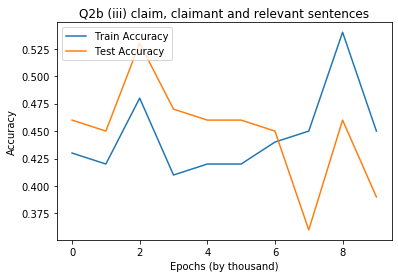

In [36]:
plt.figure()
plt.plot(all_train_accuracies_3)
plt.plot(all_test_accuracies_3)
plt.title('Q2b (iii) claim, claimant and relevant sentences')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (by thousand)')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')

In [ ]:
plt.figure()
plt.plot(all_train_accuracies)
plt.plot(all_train_accuracies_2)
plt.plot(all_train_accuracies_3)
plt.title('Q2b Train Accuracy')
plt.ylabel('Train accuracy')
plt.xlabel('Epochs (by thousand)')
plt.legend(['i) claim', 'ii) claim and claimant', 'iii) claim and claimand and relevant sentences'], loc='upper left')
plt.show()

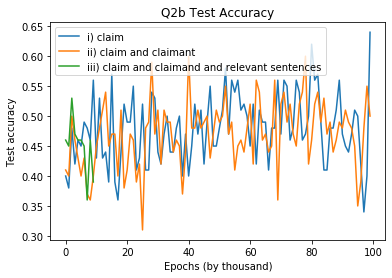

In [38]:
plt.figure()
plt.plot(all_test_accuracies)
plt.plot(all_test_accuracies_2)
plt.plot(all_test_accuracies_3)
plt.title('Q2b Test Accuracy')
plt.ylabel('Test accuracy')
plt.xlabel('Epochs (by thousand)')
plt.legend(['i) claim', 'ii) claim and claimant', 'iii) claim and claimand and relevant sentences'], loc='upper left')
plt.show()

*Based on the above graph it is clear that the test accuracies remain constant around 50% which shows that we have lot more to improve on*